# Feature Filtering

This notebook performs an initial selection of features for model training. Since high correlations between features can lead to overfitting, the dataset is first analyzed for correlations, and one feature from each highly correlated pair is removed.

A more specific feature space reduction will be part of the model training process, as part of hyperparameter tuning. The reason being, that the optimal feature space dimension can be highly dependent on the model used.

In [271]:
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [272]:
# ---- LOAD DATA ----

df = pd.read_csv("../data/processed/labeled_feature_matrix.csv")
X = df.drop(columns=["performance_class"])
y = df["performance_class"]

# Filter by Variance

Schwache Features (Varianz < 0.01): ['Comparison_HRV_VHF', 'HRV_VLF', 'Comparison_HRV_VLF', 'HRV_VHF', 'Comparison_HRV_HF', 'HRV_LF', 'Comparison_HRV_CVNN', 'Comparison_HRV_LF', 'Comparison_HRV_CVSD', 'Comparison_HRV_MCVNN', 'Comparison_HRV_TP', 'HRV_HF', 'HRV_MCVNN', 'HRV_TP', 'HRV_CVNN', 'Comparison_HRV_LFn']
Behaltene Features nach Varianz-Filterung: ['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'Comparison_HRV_MeanNN', 'Comparison_HRV_SDNN', 'Comparison_HRV_SDANN1', 'Comparison_HRV_SDNNI1', 'Comparison_HRV_RMSSD', 'Comparison_HRV_SDSD', 'Comparison_HRV_MedianNN', 'Comparison_HRV_MadNN', 'Comparison_HRV_IQRNN', 'Comparison_HRV_SDRMSSD', 'Comparison_HRV_Prc20NN', 'Comparison_HRV_Prc80NN', 'Comparison_HRV_pNN50', 'Comparison_HRV_pNN20'

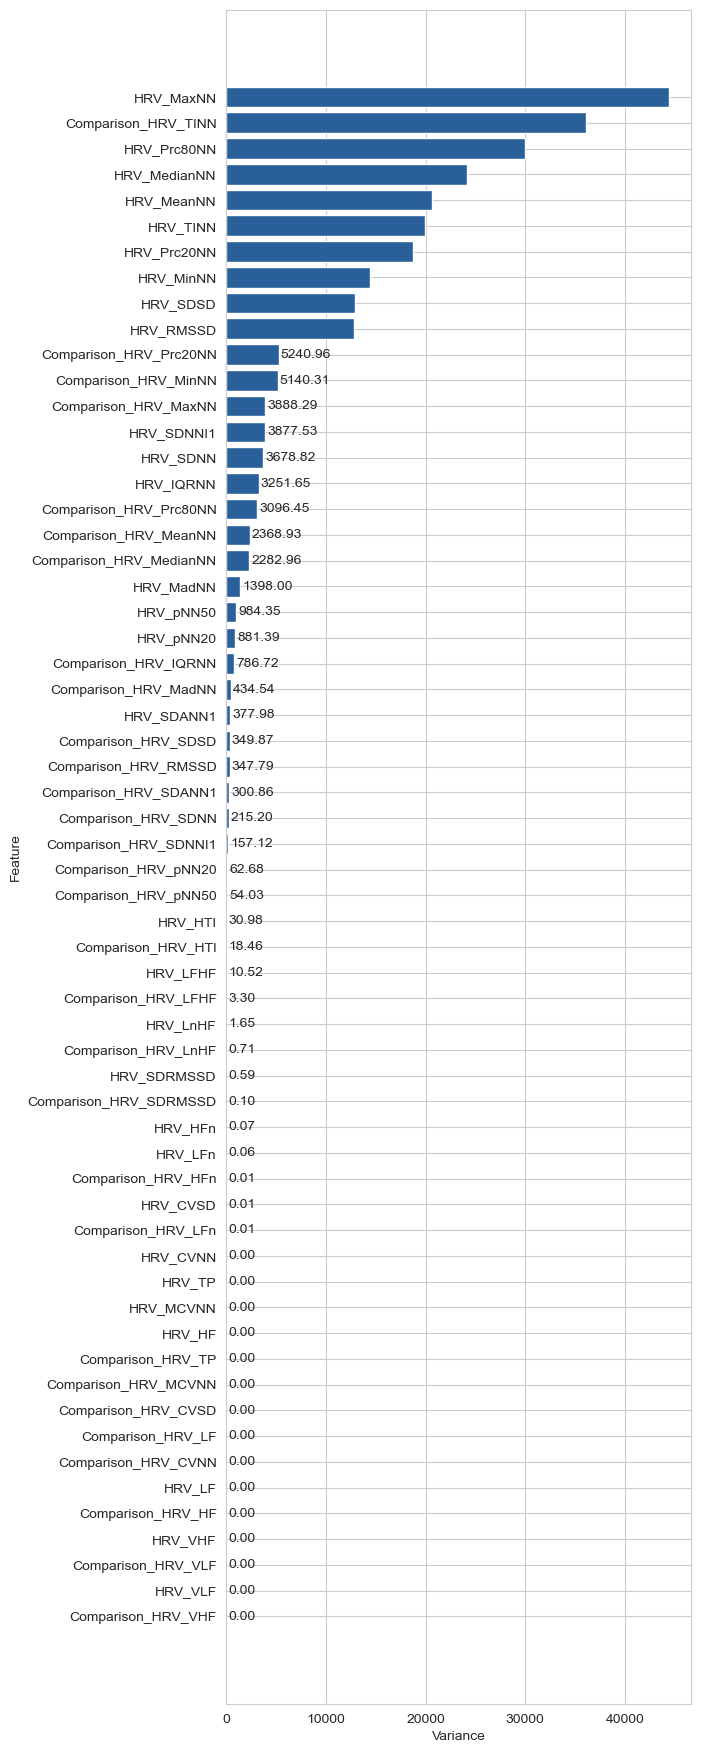

In [273]:
# ---- REMOVE FEATURES WITH LOW VARIANCE ----

variance_threshold = 0.01
var_selector = VarianceThreshold(threshold=variance_threshold)
X_var_filtered = var_selector.fit_transform(X)
var_scores = var_selector.variances_

# In DataFrame speichern
feature_names = X.columns
variance_df = pd.DataFrame({"Feature": feature_names, "Variance": var_scores})
variance_df = variance_df.sort_values(by="Variance", ascending=True)

# Features mit geringer Varianz markieren
weak_features = variance_df[variance_df["Variance"] < variance_threshold]["Feature"].tolist()
print("Schwache Features (Varianz < 0.01):", weak_features)

# Behaltene Features abrufen
selected_var_features = X.columns[var_selector.get_support()]
print(f"Behaltene Features nach Varianz-Filterung: {list(selected_var_features)}")

# Aktualisiere X mit den gefilterten Features
X = pd.DataFrame(X_var_filtered, columns=selected_var_features)

# Erstelle ein Balkendiagramm
plt.figure(figsize=(6, 22))
bars = plt.barh(variance_df["Feature"], variance_df["Variance"], color='#296099')
plt.xlabel("Variance")
plt.ylabel("Feature")

# Add variance values to the bars
for bar in bars:
    if bar.get_width() < 10000:
        plt.text(bar.get_width() + 200, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.show()

In [274]:
# ---- FEATURE SCALING ----

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Filter Highly Correlated Features

Features, that are highly correlated to each other are redundant and can lead to overfitting. To avoid this, we remove one feature from each highly correlated pair.

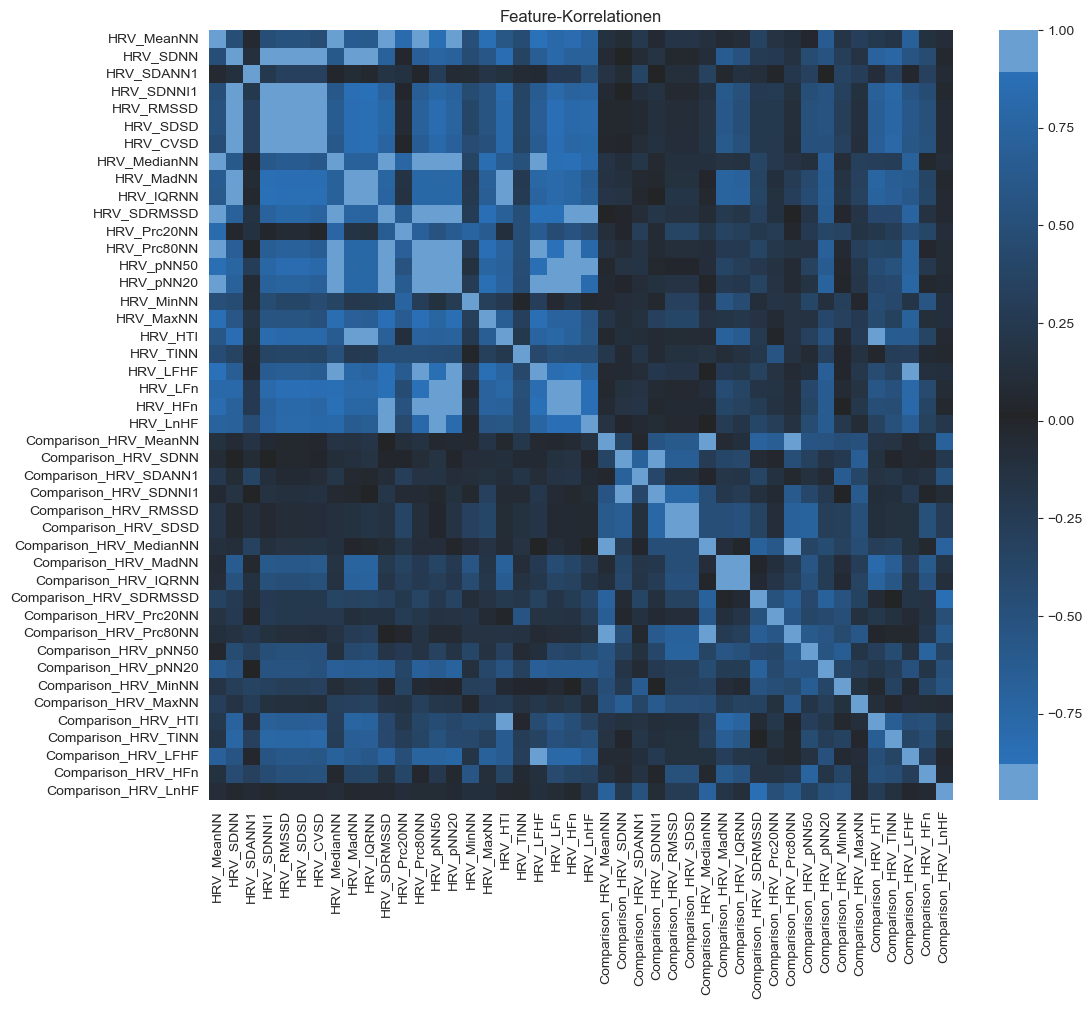

Feature pairs with correlation < -0.9 or > 0.9:
('HRV_SDNNI1', 'HRV_SDNN', np.float64(0.9943177048806423))
('HRV_RMSSD', 'HRV_SDNN', np.float64(0.96932088528443))
('HRV_RMSSD', 'HRV_SDNNI1', np.float64(0.9842936605903037))
('HRV_SDSD', 'HRV_SDNN', np.float64(0.969295590075651))
('HRV_SDSD', 'HRV_SDNNI1', np.float64(0.9842721720321346))
('HRV_SDSD', 'HRV_RMSSD', np.float64(0.9999999813558494))
('HRV_CVSD', 'HRV_SDNN', np.float64(0.9746501245758151))
('HRV_CVSD', 'HRV_SDNNI1', np.float64(0.9889674737045508))
('HRV_CVSD', 'HRV_RMSSD', np.float64(0.9977543594328699))
('HRV_CVSD', 'HRV_SDSD', np.float64(0.997742020945412))
('HRV_MedianNN', 'HRV_MeanNN', np.float64(0.9857418743384898))
('HRV_IQRNN', 'HRV_SDNN', np.float64(0.9051032194042907))
('HRV_IQRNN', 'HRV_MadNN', np.float64(0.9923563316503211))
('HRV_SDRMSSD', 'HRV_MeanNN', np.float64(-0.9080634445692298))
('HRV_SDRMSSD', 'HRV_MedianNN', np.float64(-0.9367246037766445))
('HRV_Prc80NN', 'HRV_MeanNN', np.float64(0.97044052171467))
('HRV_

In [275]:
# ---- REMOVE HIGHLY CORRELATED FEATURES ----

# Calculate correlation matrix
corr_matrix = X_scaled.corr()

# Plot heatmap
# Create a custom colormap
def custom_colormap():
    cmap = sns.diverging_palette(610, 610, as_cmap=True, center="dark", s=90)
    cmap_colors = cmap(np.arange(cmap.N))
    custom_color = np.array([106/255, 160/255, 209/255, 1]) 
    white = np.array([1, 1, 1, 1])
    threshold_high = int(0.95 * (cmap.N - 1))
    threshold_low = int(-0.96 * (cmap.N - 1))
    cmap_colors[threshold_high:] = custom_color  # Set values > 0.9 to white
    cmap_colors[:threshold_low] = custom_color   # Set values < -0.9 to white
    return ListedColormap(cmap_colors)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, annot=False, cmap=custom_colormap(), fmt=".2f")
plt.title("Feature-Korrelationen")
plt.show()

fig = heatmap.get_figure()
fig.savefig("../data/figures/02_feature_correlation_heatmap.pdf") 

# Find feature pairs with correlation < -0.9 or > 0.9, excluding the diagonal
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] < -0.9 or corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Print the high correlation pairs
print("Feature pairs with correlation < -0.9 or > 0.9:")
for pair in high_corr_pairs:
    print(pair)

# Remove one feature from each pair if the second feature is still in X_scaled
features_to_remove = set()
for pair in high_corr_pairs:
    if pair[0] in X_scaled.columns and pair[1] in X_scaled.columns:
        features_to_remove.add(pair[0])
        X_scaled = X_scaled.drop(columns=pair[0])



print(f"Removed features: {features_to_remove}")


## FILTER BY ANOVA SCORE

Schwache Features (ANOVA Score < 0.5): ['Comparison_HRV_pNN50', 'Comparison_HRV_HFn', 'HRV_pNN50', 'HRV_Prc20NN', 'HRV_TINN', 'Comparison_HRV_MaxNN']


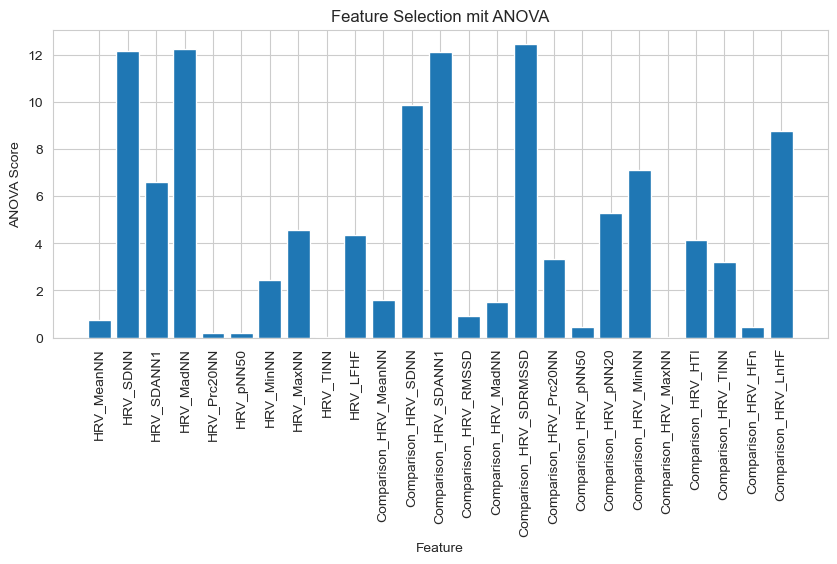

In [276]:
# ---- ANOVA FEATURE FILTER ----

anova_selector = SelectKBest(score_func=f_classif, k="all")
X_anova = anova_selector.fit_transform(X_scaled, y)
selected_features_anova = X_scaled.columns[anova_selector.get_support()]

anova_scores = anova_selector.scores_
feature_names = X_scaled.columns

# In DataFrame speichern
anova_df = pd.DataFrame({"Feature": feature_names, "ANOVA Score": anova_scores})
anova_df = anova_df.sort_values(by="ANOVA Score", ascending=False)

# Features mit schwachem ANOVA Score markieren
weak_features = anova_df[anova_df["ANOVA Score"] < 0.5]["Feature"].tolist()

# Ergebnisse anzeigen
print("Schwache Features (ANOVA Score < 0.5):", weak_features)

plt.figure(figsize=(10, 4))
plt.bar(feature_names, anova_scores)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("ANOVA Score")
plt.title("Feature Selection mit ANOVA")
plt.show()


# Aktualisiere X mit den gefilterten Features
# Remove weak features from X_scaled
X_scaled = X_scaled.drop(columns=weak_features)

In [277]:
# ---- SAVE FILTERED FEATURE MATRIX ----

X_scaled_with_y = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

X_scaled_with_y.to_csv("../data/features/filtered_labeled_feature_matrix.csv", index=False)

print("Feature Selection abgeschlossen! Reduzierte Daten gespeichert in data/features/selected_features.csv")


Feature Selection abgeschlossen! Reduzierte Daten gespeichert in data/features/selected_features.csv
